In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import os
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms import bipartite
import igraph as ig
import leidenalg as la

# Flash Assignment 2
Emil Künstner, Xun Li

## 1. EDA

In [10]:
# Load the dataset
youtube_data = pd.read_csv("youtube_cross_platform.csv")

twitter_data = pd.read_csv("twitter_cross_platform.csv")
facebook_data = pd.read_csv("facebook_cross_platform.csv")
reddit_data = pd.read_csv("reddit_cross_platform.csv")

for df in [youtube_data, twitter_data, facebook_data, reddit_data]:
    df['nodeTime'] = pd.to_datetime(df['nodeTime'])

all_data = pd.concat([youtube_data, twitter_data, facebook_data, reddit_data], ignore_index=True)
data = pd.concat([twitter_data, facebook_data, reddit_data], ignore_index=True)

twitter_data['nodeTime'] = pd.to_datetime(twitter_data['nodeTime'])

twitter_data = twitter_data[['nodeUserID', 'videoID', 'nodeTime']]

In [11]:
data.head()

,nodeID,nodeUserID,nodeTime,actionType,videoID,platform
0,NRFEnex8MF21dytDg9vfAg,ff0vicGZco1mZzYxUCWiGg,2018-04-01 02:13:00,tweet,6h0VDhENotI,twitter
1,Qeyxwl00d0vgLfKh1YqUEw,MCUuXxcepDc2FFRh9i-AtQ,2018-04-01 03:34:41,tweet,NQL3rX6xWRg,twitter
2,1QIQqg23ItMfiKbFFrPkAw,5hBVs8jS6_vCAFsHOjvKcA,2018-04-01 10:23:20,tweet,VLMOHhKkrX8,twitter
3,iYMBH3KdJvOiUHYxeKfx_w,qhQLCsDQNEtptuJJzfEVZA,2018-04-01 11:13:02,tweet,VLMOHhKkrX8,twitter
4,G86DyDFas0zLKkBFW0GWwg,lSmQYvUcuGn6oFyjGJduDw,2018-04-01 13:43:07,tweet,4oQTWn1JfeA,twitter


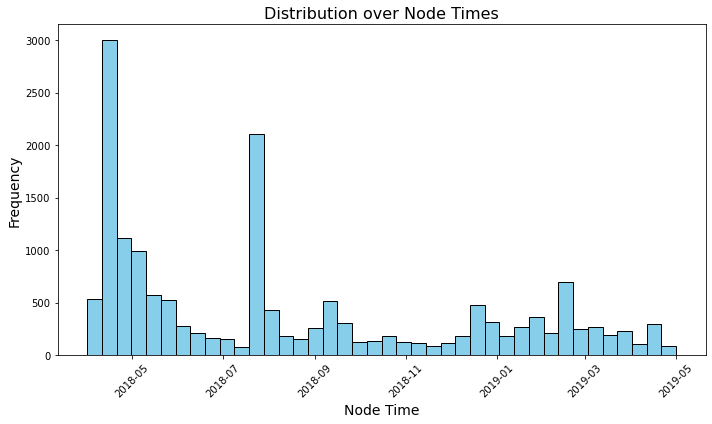

In [17]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(data['nodeTime'], bins=40, color='skyblue', edgecolor='black')

plt.title('Distribution over Node Times', fontsize=16)
plt.xlabel('Node Time', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 2. Build a bipart graph. Find the largest connected group. Get it projection on user only.

In [14]:
G = nx.Graph()

# Add nodes and edges
for _, row in twitter_data.iterrows():
    user = row['nodeUserID']
    video = row['videoID']
    
    G.add_node(user, bipartite=0)  # Users
    G.add_node(video, bipartite=1)  # Videos
    
    G.add_edge(user, video)

# Find the largest connected component
largest_cc = max(nx.connected_components(G), key=len)

# Create a subgraph with the largest connected component
G_largest = G.subgraph(largest_cc).copy()


In [15]:
# Check connected components
components = list(nx.connected_components(G))
print(f"Number of connected components: {len(components)}")

# Largest connected component
largest_component = max(components, key=len)
print(f"Size of the largest component: {len(largest_component)}")



Number of connected components: 116
Size of the largest component: 5235


Visualize the bipart graph.

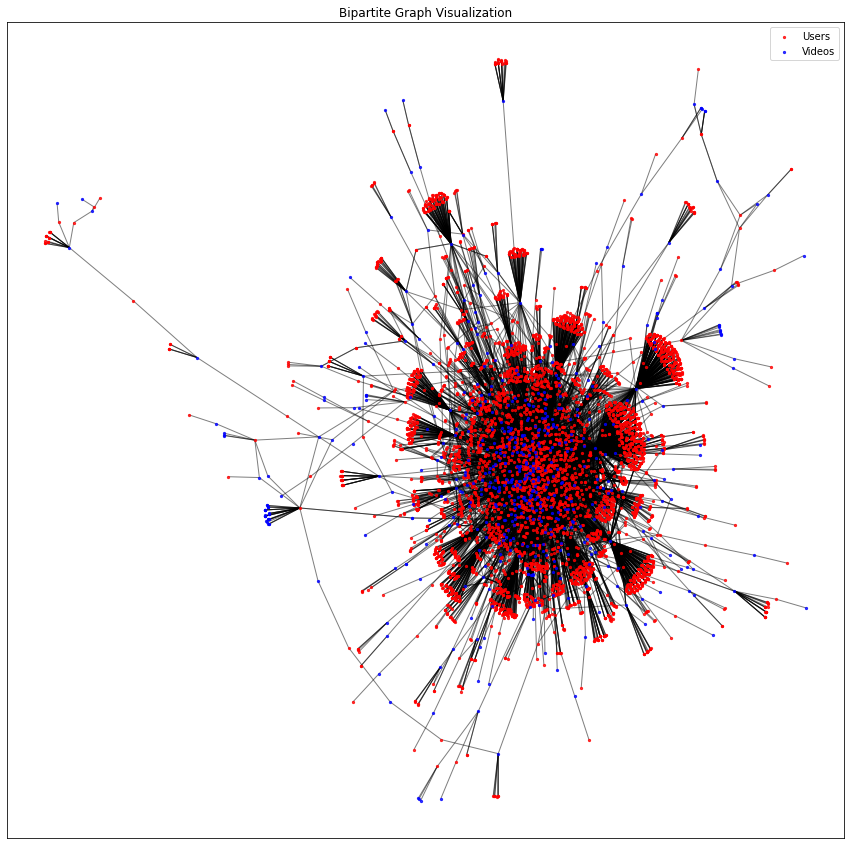

In [16]:
# Visualize the Graph
plt.figure(figsize=(15, 15))  # Set the figure size (width, height) in inches
pos = nx.spring_layout(G_largest)  # positions for all nodes

# Separate the nodes by bipartite set
users = {n for n, d in G_largest.nodes(data=True) if d['bipartite'] == 0}
videos = set(G_largest) - users

nx.draw_networkx_nodes(G_largest, pos, nodelist=users, node_color='r', node_size=5, alpha=0.8, label='Users')
nx.draw_networkx_nodes(G_largest, pos, nodelist=videos, node_color='b', node_size=5, alpha=0.8, label='Videos')

nx.draw_networkx_edges(G_largest, pos, width=1.0, alpha=0.5)
plt.legend(scatterpoints=1)
plt.title('Bipartite Graph Visualization')
plt.show()

Get the user-only projection graph, with weighted edges. The weights are the number of shared videos between users.

In [17]:
user_projection = bipartite.weighted_projected_graph(G_largest, users)

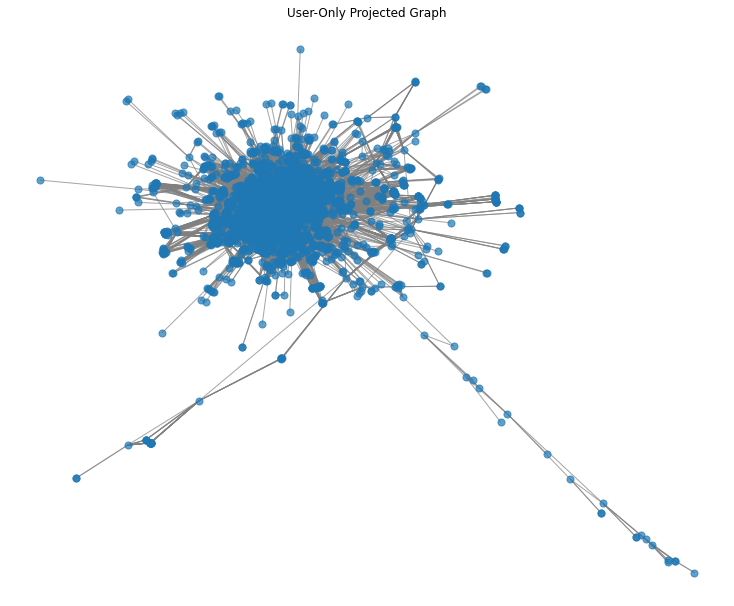

In [18]:
# Draw the user-only graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(user_projection)
nx.draw(
    user_projection,
    pos=pos,
    with_labels=False,
    node_size=50,
    edge_color="gray",
    alpha=0.7
)

plt.title("User-Only Projected Graph")
plt.show()

# 2. Find communities.

Try Greedy modularity algorithm to detect the communities.

In [19]:
communities = greedy_modularity_communities(user_projection)

# Print communities
for i, community in enumerate(communities):
    print(f"Community {i+1}: {len(community)} users")

Community 1: 1902 users
Community 2: 1313 users
Community 3: 314 users
Community 4: 234 users
Community 5: 229 users
Community 6: 221 users
Community 7: 118 users
Community 8: 90 users
Community 9: 52 users
Community 10: 45 users
Community 11: 25 users
Community 12: 21 users
Community 13: 19 users
Community 14: 17 users
Community 15: 13 users
Community 16: 12 users
Community 17: 10 users
Community 18: 9 users
Community 19: 8 users
Community 20: 7 users
Community 21: 7 users
Community 22: 5 users
Community 23: 5 users
Community 24: 4 users
Community 25: 4 users
Community 26: 4 users
Community 27: 4 users
Community 28: 4 users
Community 29: 3 users
Community 30: 3 users
Community 31: 2 users


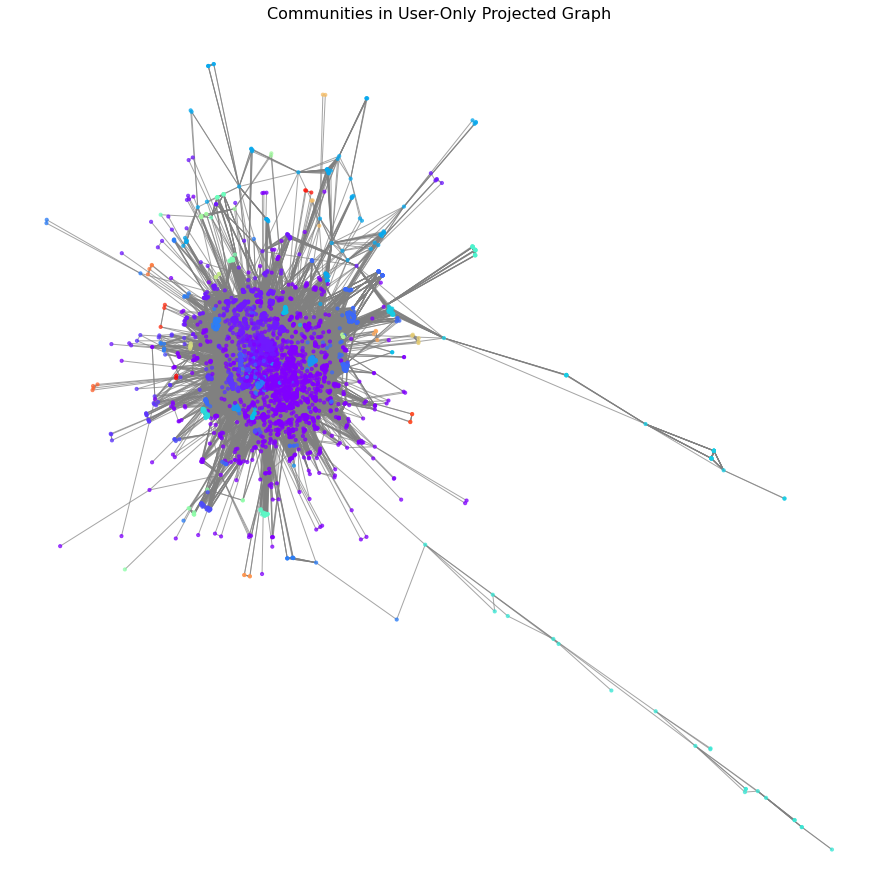

In [20]:
node_community_map = {}
for i, community in enumerate(communities):
    for node in community:
        node_community_map[node] = i
# Assign a color to each community
colors = [node_community_map[node] for node in user_projection.nodes]

# Visualize the graph with communities
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(user_projection)  # Layout for positioning nodes
nx.draw(
    user_projection,
    pos,
    with_labels=False,
    node_color=colors,
    node_size=10,
    cmap=plt.cm.rainbow,  # Use a colormap for community colors
    edge_color="gray",
    alpha=0.7
)
plt.title("Communities in User-Only Projected Graph", fontsize=16)
plt.show()

Try Leiden Algorithm

Why Choose Leiden Algorithm?

Improved Modularity: Achieves better optimization than Louvain.

Stable Communities: Produces consistent and meaningful results.

Handles Edge Weights: Takes weights into account when clustering.

Scalable: Can handle large graphs efficiently.


In [21]:
# Convert NetworkX graph to iGraph
user_projection_igraph = ig.Graph.TupleList(user_projection.edges(data=True), directed=False)

# Add weights
weights = [data["weight"] if "weight" in data else 1 for _, _, data in user_projection.edges(data=True)]
user_projection_igraph.es["weight"] = weights

NameError: name 'ig' is not defined

In [ ]:
partition = la.find_partition(
    user_projection_igraph, la.ModularityVertexPartition, weights="weight"
)

# Get communities
communities = [community for community in partition]
print(f"Number of communities detected: {len(communities)}")

node_community_map = {}
for community_id, community in enumerate(communities):
    for node in community:
        node_community_map[user_projection_igraph.vs[node]["name"]] = community_id

Number of communities detected: 19


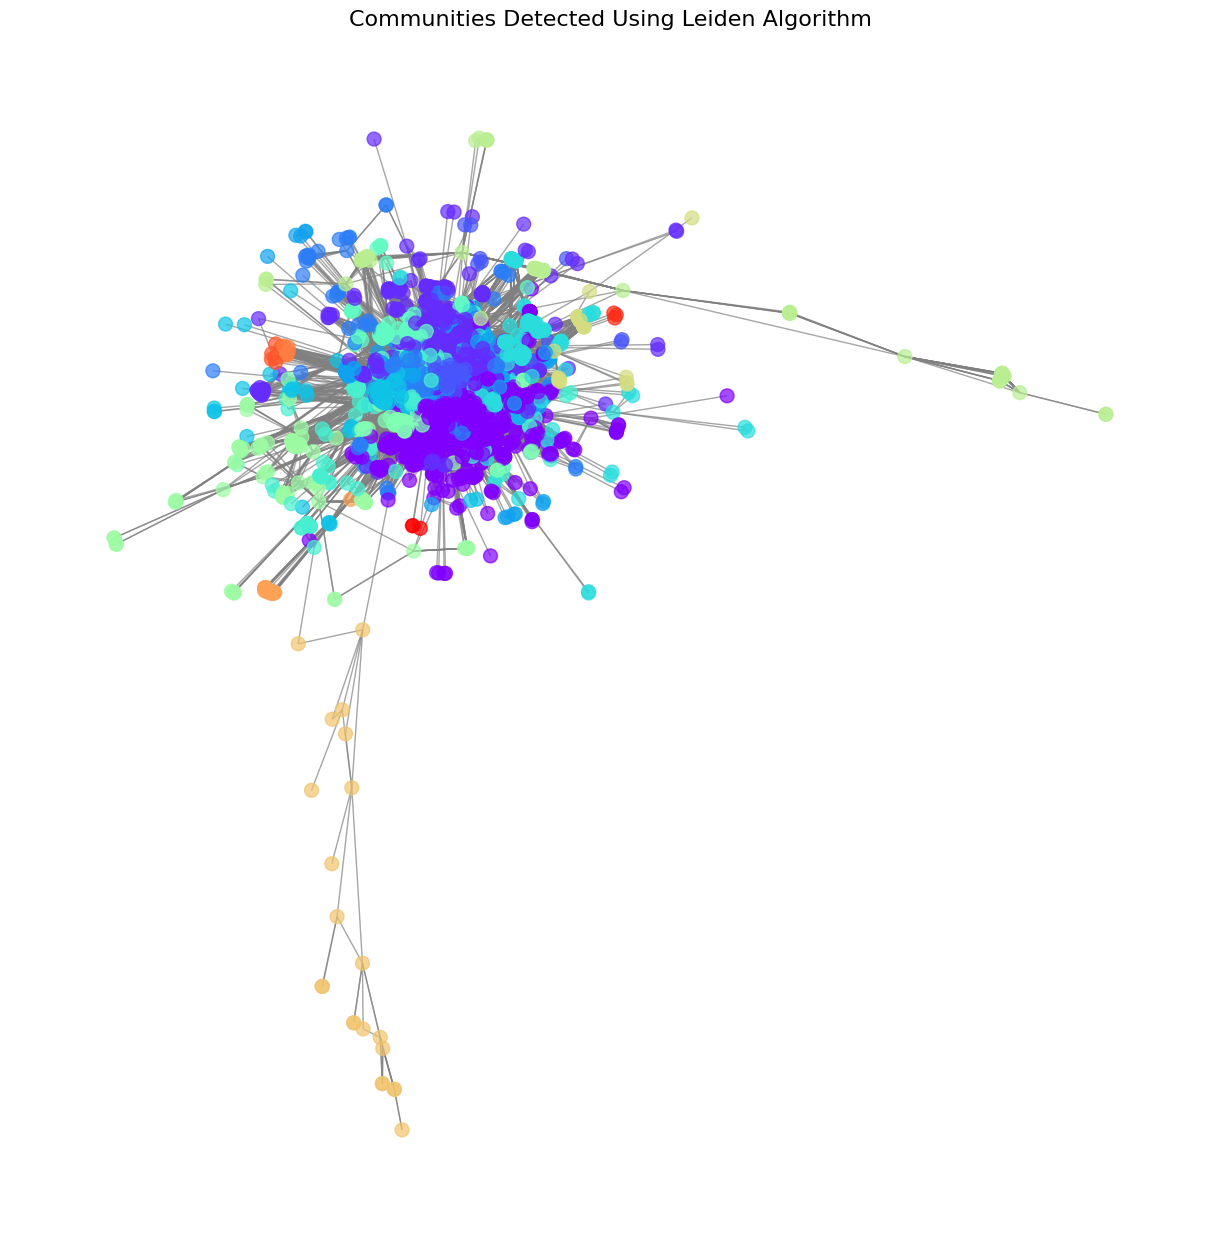

In [ ]:
# Assign a color to each community
colors = [node_community_map[node] for node in user_projection.nodes()]

# Visualize the graph with communities
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(user_projection)  # Layout for positioning nodes
nx.draw(
    user_projection,
    pos,
    with_labels=False,
    node_color=colors,
    node_size=100,
    cmap=plt.cm.rainbow,
    edge_color="gray",
    alpha=0.7
)
plt.title("Communities Detected Using Leiden Algorithm", fontsize=16)
plt.show()

In [ ]:
# Reconstruct communities
communities = {i: [] for i in set(node_community_map.values())}
for node, comm in node_community_map.items():
    communities[comm].append(node)

# Check density
for comm_id, nodes in communities.items():
    subgraph = user_projection.subgraph(nodes)
    density = nx.density(subgraph)
    print(f"Community {comm_id}: {len(nodes)} nodes, {subgraph.number_of_edges()} edges, Density: {density}")

Community 0: 1137 nodes, 38554 edges, Density: 0.05969811834949893
Community 1: 659 nodes, 13307 edges, Density: 0.06137603719368482
Community 2: 631 nodes, 191307 edges, Density: 0.9624783035242623
Community 3: 408 nodes, 23993 edges, Density: 0.288974803680686
Community 4: 364 nodes, 26548 edges, Density: 0.40184058365876546
Community 5: 328 nodes, 43770 edges, Density: 0.8161781159095994
Community 6: 315 nodes, 11332 edges, Density: 0.22913759983823678
Community 7: 270 nodes, 11903 edges, Density: 0.3277708935701501
Community 8: 205 nodes, 7855 edges, Density: 0.37565758010521283
Community 9: 128 nodes, 2838 edges, Density: 0.34916338582677164
Community 10: 92 nodes, 512 edges, Density: 0.12231247013855709
Community 11: 66 nodes, 492 edges, Density: 0.22937062937062938
Community 12: 31 nodes, 207 edges, Density: 0.44516129032258067
Community 13: 22 nodes, 34 edges, Density: 0.1471861471861472
Community 14: 20 nodes, 190 edges, Density: 1.0
Community 15: 17 nodes, 136 edges, Density:

The Leiden Algorithm finds 18 communities while greedy modularity algorithm finds 25. 

We also calculate the density of each community from the Leiden Algorithm.

# Discuassion

From the density of each group, we can easily noticed that there are big communities with significantly high density, which are not normal in organic behaviours, especially for large group. Community 2 and Community 5 has 0.96 and 0.82 density respectively. Regarding group with less nodes, for example comminity 16, 17 and 18, the 1 density could be explained that the same entity is managing several accounts, which is normal. 